In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import pytz
import glob
import os
import re

# Prepare the Dataset for Unsupervised Learning

In [3]:
nfl_games_juice_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\sportsbook_data_ALL_with_Juice.csv'
nfl_games_juice_df = pd.read_csv(nfl_games_juice_file)

C:\Users\benny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,6,7,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Create a Time Label in Hours from th

In [29]:
game_time_str = nfl_games_juice_df.loc[:,'Game Time']
game_time_str = game_time_str.str.slice(0,19)
timestamp_str = nfl_games_juice_df.loc[:,'timestamp_est']
timestamp_str = timestamp_str.str.slice(0,19)

print(game_time_str)
print(timestamp_str)


0         2018-09-06 20:20:00
1         2018-09-06 20:20:00
2         2018-09-06 20:20:00
3         2018-09-06 20:20:00
4         2018-09-06 20:20:00
5         2018-09-06 20:20:00
6         2018-09-06 20:20:00
7         2018-09-06 20:20:00
8         2018-09-06 20:20:00
9         2018-09-06 20:20:00
10        2018-09-06 20:20:00
11        2018-09-06 20:20:00
12        2018-09-06 20:20:00
13        2018-09-06 20:20:00
14        2018-09-06 20:20:00
15        2018-09-06 20:20:00
16        2018-09-06 20:20:00
17        2018-09-06 20:20:00
18        2018-09-06 20:20:00
19        2018-09-06 20:20:00
20        2018-09-06 20:20:00
21        2018-09-06 20:20:00
22        2018-09-06 20:20:00
23        2018-09-06 20:20:00
24        2018-09-06 20:20:00
25        2018-09-06 20:20:00
26        2018-09-06 20:20:00
27        2018-09-06 20:20:00
28        2018-09-06 20:20:00
29        2018-09-06 20:20:00
                 ...         
418678    2018-12-30 16:25:00
418679    2018-12-30 16:25:00
418680    

In [32]:
game_time_date = pd.to_datetime(game_time_str, format='%Y-%m-%d %H:%M:%S')
timestamp_date = pd.to_datetime(timestamp_str, format='%Y-%m-%d %H:%M:%S')
print(game_time_date)
print(timestamp_date)

0        2018-09-06 20:20:00
1        2018-09-06 20:20:00
2        2018-09-06 20:20:00
3        2018-09-06 20:20:00
4        2018-09-06 20:20:00
5        2018-09-06 20:20:00
6        2018-09-06 20:20:00
7        2018-09-06 20:20:00
8        2018-09-06 20:20:00
9        2018-09-06 20:20:00
10       2018-09-06 20:20:00
11       2018-09-06 20:20:00
12       2018-09-06 20:20:00
13       2018-09-06 20:20:00
14       2018-09-06 20:20:00
15       2018-09-06 20:20:00
16       2018-09-06 20:20:00
17       2018-09-06 20:20:00
18       2018-09-06 20:20:00
19       2018-09-06 20:20:00
20       2018-09-06 20:20:00
21       2018-09-06 20:20:00
22       2018-09-06 20:20:00
23       2018-09-06 20:20:00
24       2018-09-06 20:20:00
25       2018-09-06 20:20:00
26       2018-09-06 20:20:00
27       2018-09-06 20:20:00
28       2018-09-06 20:20:00
29       2018-09-06 20:20:00
                 ...        
418678   2018-12-30 16:25:00
418679   2018-12-30 16:25:00
418680   2018-12-30 16:25:00
418681   2018-

In [38]:
diff = (game_time_date - timestamp_date).astype('timedelta64[h]')
print(diff)
nfl_games_juice_df['Hours To Game'] = diff

0         104.0
1         171.0
2         170.0
3         169.0
4         168.0
5         167.0
6         154.0
7         153.0
8         152.0
9         151.0
10        150.0
11        149.0
12        148.0
13        147.0
14        146.0
15        145.0
16        144.0
17        143.0
18        142.0
19        141.0
20        140.0
21        139.0
22        138.0
23        137.0
24        136.0
25        135.0
26        134.0
27        133.0
28        132.0
29        131.0
          ...  
418678     28.0
418679     27.0
418680     26.0
418681     25.0
418682     24.0
418683     23.0
418684     22.0
418685     21.0
418686     20.0
418687     19.0
418688     18.0
418689     17.0
418690     16.0
418691     15.0
418692     14.0
418693     13.0
418694     12.0
418695     11.0
418696     10.0
418697      9.0
418698      8.0
418699      7.0
418700      6.0
418701      5.0
418702      4.0
418703      3.0
418704      3.0
418705      2.0
418706      1.0
418707      0.0
Length: 418708, dtype: f

In [47]:
nfl_games_juice_hours_df = nfl_games_juice_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread points','Away Pointspread odds','Home Pointspread points','Home Pointspread odds','Total points','Over odds','Under odds','Away_x','Home_x','Game','Game Number','timestamp_est','Winner/tie','Loser/tie','PtsW','PtsL','YdsW','TOW','YdsL','TOL','Home_y','Away_y','Game Time','Pre-Game','Juice Moneyline','Juice Pointspread','Juice Total','Hours To Game']]
print(nfl_games_juice_hours_df.head())

        Book Away Moneyline Home Moneyline Away Pointspread points  \
0   alfabook            115           -135                     2.5   
1  bravobook            NaN            NaN                       3   
2  bravobook            NaN            NaN                       3   
3  bravobook            NaN            NaN                       3   
4  bravobook            NaN            NaN                       3   

   Away Pointspread odds Home Pointspread points  Home Pointspread odds  \
0                 -110.0                    -2.5                 -110.0   
1                 -119.0                      -3                 -101.0   
2                 -110.0                      -3                 -110.0   
3                 -110.0                      -3                 -110.0   
4                 -110.0                      -3                 -110.0   

   Total points  Over odds  Under odds      ...       YdsL TOL  \
0          45.5     -108.0      -112.0      ...        299   1

In [48]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
nfl_games_juice_hours_df.to_csv(export_path+"\\sportsbook_data_ALL_with_Juice_Hours.csv")

In [71]:
nfl_games_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project\sportsbook_data_ALL_with_Juice_Hours.csv'
nfl_games_df = pd.read_csv(nfl_games_file)

In [72]:
nfl_games_df["Book"] = nfl_games_df["Book"].astype('category')
nfl_games_df["Book Encoded"] = nfl_games_df["Book"].cat.codes
nfl_games_df.reset_index(drop=True, inplace=True)
print(nfl_games_df.head())

   Unnamed: 0       Book Away Moneyline Home Moneyline  \
0           0   alfabook            115           -135   
1           1  bravobook            NaN            NaN   
2           2  bravobook            NaN            NaN   
3           3  bravobook            NaN            NaN   
4           4  bravobook            NaN            NaN   

  Away Pointspread points  Away Pointspread odds Home Pointspread points  \
0                     2.5                 -110.0                    -2.5   
1                       3                 -119.0                      -3   
2                       3                 -110.0                      -3   
3                       3                 -110.0                      -3   
4                       3                 -110.0                      -3   

   Home Pointspread odds  Total points  Over odds      ...       TOL  \
0                 -110.0          45.5     -108.0      ...         1   
1                 -101.0          45.5     -105.0 

# Create Time Series with 120 Hours of Odds into the Game

In [76]:
nfl_games_120_df = nfl_games_df[(nfl_games_df['Hours To Game']<120) & (nfl_games_df['Hours To Game']>=0)]
print(nfl_games_df.shape)
print(nfl_games_120_df.shape)

(418708, 33)
(192815, 33)


In [77]:
nfl_games_120_df = nfl_games_120_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread odds','Home Pointspread odds','Over odds','Under odds','Game Number','Hours To Game','Book Encoded']]
#nfl_games_24_df = nfl_games_24_df[['Book','Away Moneyline','Home Moneyline','Away Pointspread odds','Home Pointspread odds','Over odds','Under odds','Game Number','Hours To Game']]
print(nfl_games_120_df.shape)

(192815, 10)


In [78]:
sportsbook_ids = [s for s in range(0, 12)]
game_ids = [i for i in range(1, 177)]
hours_ids = [z for z in range(119,-1,-1)]
print(sportsbook_ids)
print(game_ids)
print(hours_ids)
print(nfl_games_120_df.dtypes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
[119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,

In [ ]:
away_moneyline_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Away Moneyline']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            away_moneyline_time_series.append(odds_series)


In [93]:
away_moneyline_time_series_df = pd.DataFrame(away_moneyline_time_series)
print(away_moneyline_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_moneyline_time_series_df.to_csv(export_path+"\\away_moneyline_time_series_120_df.csv")

(1582, 26)


In [94]:
home_moneyline_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Home Moneyline']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_24_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            home_moneyline_time_series.append(odds_series)

In [95]:
home_moneyline_time_series_df = pd.DataFrame(home_moneyline_time_series)
print(home_moneyline_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_moneyline_time_series_df.to_csv(export_path+"\\home_moneyline_time_series_120_df.csv")

(1582, 26)


In [96]:
away_pointspread_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Away Pointspread odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_24_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            away_pointspread_time_series.append(odds_series)

In [97]:
away_pointspread_time_series_df = pd.DataFrame(away_pointspread_time_series)
print(away_pointspread_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
away_pointspread_time_series_df.to_csv(export_path+"\\away_pointspread_time_series_120_df.csv")

(1582, 26)


In [98]:
home_pointspread_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Home Pointspread odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            home_pointspread_time_series.append(odds_series)

In [99]:
home_pointspread_time_series_df = pd.DataFrame(home_pointspread_time_series)
print(home_pointspread_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
home_pointspread_time_series_df.to_csv(export_path+"\\home_pointspread_time_series_120_df.csv")

(1582, 26)


In [100]:
over_odds_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Over odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            over_odds_time_series.append(odds_series)

In [101]:
over_odds_time_series_df = pd.DataFrame(over_odds_time_series)
print(over_odds_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
over_odds_time_series_df.to_csv(export_path+"\\over_odds_time_series_120_df.csv")

(1582, 26)


In [102]:
under_odds_time_series = []
for ga in game_ids:
    for sp in sportsbook_ids: 
        odds_series = []
        for hr in hours_ids:        
            odds = nfl_games_120_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Hours To Game']==hr) & (nfl_games_120_df['Book Encoded']==sp)]['Under odds']
            try:
                odds = float(odds)
                #print(odds)
            except:
                odds = float('nan')
            odds_series.append(odds)
        if nfl_games_24_df[(nfl_games_120_df['Game Number']==ga) & (nfl_games_120_df['Book Encoded']==sp)].empty:
            #print('its empty!')
            continue
        else:
            odds_series.append(ga)
            odds_series.append(sp)
            under_odds_time_series.append(odds_series)

In [103]:
under_odds_time_series_df = pd.DataFrame(under_odds_time_series)
print(under_odds_time_series_df.shape)
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
under_odds_time_series_df.to_csv(export_path+"\\under_odds_time_series_120_df.csv")

(1582, 26)


In [7]:
moneyline_odds_file = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Unsupervised\moneyline.csv'
moneyline_odds_time_series_df = pd.read_csv(moneyline_odds_file)
moneyline_odds_clustering = moneyline_odds_time_series_df.iloc[:,0:120]

# Unsupervised Learning Implementation

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

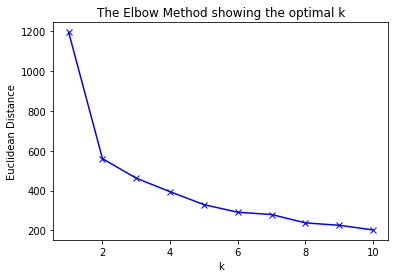

[1196.1069950392632, 560.3560630812407, 462.15616916308613, 394.1965514548991, 329.3084447571568, 291.17867199757274, 279.5866513066788, 237.63589770143767, 225.3884678045937, 202.18982383584938]


In [9]:
# k means determine k
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(moneyline_odds_clustering)
    kmeanModel.fit(moneyline_odds_clustering)
    distortions.append(sum(np.min(cdist(moneyline_odds_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / moneyline_odds_clustering.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Euclidean Distance')
plt.title('The Elbow Method showing the optimal k')
plt.show()

print(distortions)

In [46]:
kmeans = KMeans(n_clusters=5).fit(moneyline_odds_clustering)
centroids = kmeans.cluster_centers_
print(centroids)
c= kmeans.labels_.astype(int)

[[ -165.23535062  -165.84630163  -164.54755043  -165.22286263
   -165.41786744  -165.06532181  -165.67627281  -163.98751201
   -164.77809798  -163.77521614  -168.12776177  -167.67723343
   -165.92891451  -168.04610951  -168.21517771  -166.93852065
   -165.95869356  -165.63976945  -164.71853987  -165.37944284
   -166.35542747  -165.53794428  -164.55043228  -163.26801153]
 [  625.03225806   623.5          622.29032258   628.72580645
    630.5          628.48387097   627.91935484   628.96774194
    625.12903226   628.67741935   631.01612903   632.22580645
    619.82258065   620.62903226   622.01612903   621.96774194
    622.46774194   623.82258065   626.35483871   631.93548387
    638.17741935   633.98387097   655.08064516   660.51612903]
 [  137.79689367   139.6344086    141.12425329   140.98685783
    141.72043011   141.60334528   142.04659498   142.31660693
    142.15651135   140.21146953   143.72998805   141.44444444
    139.78614098   143.14217443   144.36798088   141.13500597
    13

In [47]:
c_df = pd.DataFrame(c)
moneyline_odds_time_series_df['Cluster'] = c_df

In [48]:
export_path = r'C:\Users\benny\OneDrive\Machine Learning\ML1030\Final Project\Final Project'
moneyline_odds_time_series_df.to_csv(export_path+"\\moneyline_cluster.csv")

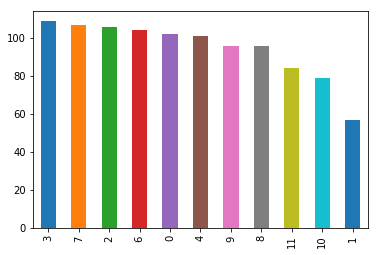

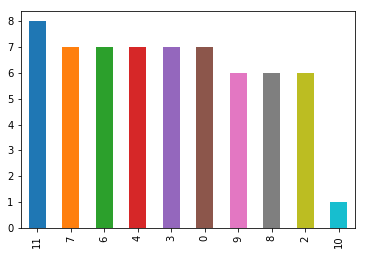

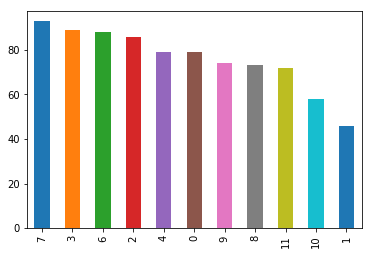

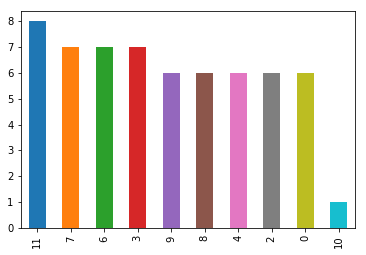

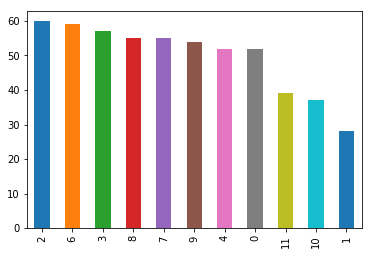

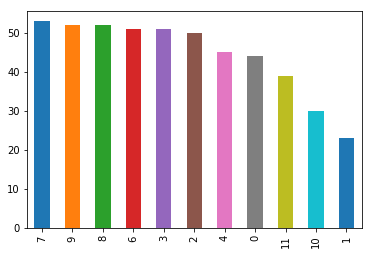

In [50]:
cluster_0_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==0]
plt.figure(1)
cluster_0_df['25'].value_counts().plot('bar')

cluster_1_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==1]
plt.figure(2)
cluster_1_df['25'].value_counts().plot('bar')

cluster_2_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==2]
plt.figure(3)
cluster_2_df['25'].value_counts().plot('bar')

cluster_3_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==3]
plt.figure(4)
cluster_3_df['25'].value_counts().plot('bar')

cluster_4_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==4]
plt.figure(5)
cluster_4_df['25'].value_counts().plot('bar')

#cluster_5_df = moneyline_odds_time_series_df[moneyline_odds_time_series_df['Cluster']==5]
#plt.figure(6)
#cluster_5_df['25'].value_counts().plot('bar')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(moneyline_odds_clustering)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
